# Matched filter determination

1. Construct function that creates matched filter in a cube
2. For each pixel in the dark hole (use bowtie function), record cube coordinates (use reshape)
3. For each coordinate, compute the matched filter taking into account the bowtie mask (watch out for photometry); record to 4D cube (first dimension is the index of the cube coordinate)
4. When applying the match filter, look up the 4D cube

### Load crispy

In [1]:
%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest'
import sys
import os

folder = '../../../../crispy'
print(folder)
if folder not in sys.path: sys.path.append(folder)

from crispy.params import Params
folder = '../../../crispy'

from crispy.tools.initLogger import getLogger
log = getLogger('crispy')
from crispy.IFS import polychromeIFS
from crispy.IFS import reduceIFSMap
from crispy.tools.imgtools import scale2imgs,bowtie
from crispy.tools.image import Image
from crispy.tools.rotate import rotateCube,shiftCube
from crispy.tools.postprocessing import mf,recenter_offaxis
from crispy.tools.inputScene import adjust_krist_header
from astropy.io import fits
par = Params(folder)


Populating the interactive namespace from numpy and matplotlib
../../../../crispy


### Matched filter in a cube

In [6]:
offaxis_ideal_before_rotate = reduceIFSMap(par,'/Users/mrizzo/IFS/OS5/OS5_average/offaxis.fits')
#offaxis_ideal = Image(data=rotateCube(offaxis_ideal_before_rotate.data,-26*np.pi/180.,clip=True))
#offaxis_ideal = Image(data=shiftCube(offaxis_ideal_before_rotate.data,dx=0,dy=-10))
offaxis_ideal = offaxis_ideal_before_rotate
offaxis_ideal.write(par.exportDir+"/test_offaxisrot.fits")
matched_filter = np.zeros(offaxis_ideal.data.shape)
ydim,xdim = offaxis_ideal.data[0].shape
IWA = 3
OWA = 9
lamc=770.
threshold = 0.5
mask,junk = bowtie(offaxis_ideal.data[0],ydim//2,xdim//2,openingAngle=65,
            clocking=-par.philens*180./np.pi,IWApix=IWA*lamc/par.lenslet_wav/par.lenslet_sampling,OWApix=OWA*lamc/par.lenslet_wav/par.lenslet_sampling,
            export=None,twomasks=False)
# for slicenum in range(offaxis_ideal.data.shape[0]):
#     nanmask = np.isnan(offaxis_ideal.data[slicenum])
#     offaxis_ideal_norm = offaxis_ideal.data[slicenum]/np.nansum(offaxis_ideal.data[slicenum])
#     this_slice = offaxis_ideal_norm/np.nansum((offaxis_ideal_norm)**2)
#     # calculate correction factor since we are going to crop only the top the of the hat
#     # this is the inverse ratio of the contribution of the brightest pixels over the rest
#     msk = mask*(this_slice>threshold)
#     aper_phot = np.nansum(this_slice)/np.nansum(this_slice[msk])
#     # Set all low-contributing pixels to 0.0
#     this_slice[~msk] = 0.0
#     this_slice[nanmask] = np.NaN
#     matched_filter[slicenum,:,:] = this_slice
#     # Multiply what is left by that aperture correction factor
#     matched_filter[slicenum,:,:]*=aper_phot
matched_filter = mf(offaxis_ideal,mask,threshold)
Image(data=matched_filter).write(par.exportDir+"/test_matched_filter.fits")

crispy - INFO - Read data from HDU 1 of /Users/mrizzo/IFS/OS5/OS5_average/offaxis.fits
crispy - INFO - Reduced cube will have 19 wavelength bins
crispy - INFO - Writing data to ../../../crispy/SimResults/offaxis_red_optext.fits
crispy - INFO - Elapsed time: 1.373560s
crispy - INFO - Writing data to ../../../crispy/SimResults/test_offaxisrot.fits
crispy - INFO - Writing data to ../../../crispy/SimResults/test_matched_filter.fits


### Recenter off-axis PSF used for matched filter

In [3]:
offaxis = Image('/Users/mrizzo/IFS/OS5/offaxis/spc_offaxis_psf.fits')
offsetpx = offaxis.header['OFFSET']/offaxis.header['PIXSIZE']
print offsetpx
centered_offaxis = Image(data=shiftCube(offaxis.data,dx=offsetpx,dy=0))
maxi = np.nanmax(np.nanmax(centered_offaxis.data,axis=2),axis=1)
total = np.nansum(np.nansum(centered_offaxis.data,axis=2),axis=1)
print total
centered_offaxis.data/=maxi[:,np.newaxis,np.newaxis]

centered_offaxis.data[centered_offaxis.data<0.01] = 0.0
newsum = np.nansum(np.nansum(centered_offaxis.data,axis=2),axis=1)
centered_offaxis.data *= maxi[:,np.newaxis,np.newaxis]#total[:,np.newaxis,np.newaxis]/newsum[:,np.newaxis,np.newaxis]
print np.nansum(np.nansum(centered_offaxis.data,axis=2),axis=1)
print "Loss:",(np.nansum(np.nansum(centered_offaxis.data,axis=2),axis=1)-total)/total*100,"%"
#centered_offaxis.write(par.exportDir+'/centered_offaxis.fits')
outkey = fits.HDUList(fits.PrimaryHDU(centered_offaxis.data,offaxis.header))
outkey.writeto(par.exportDir+'/centered_offaxis.fits',clobber=True)
slices,ny,nx = centered_offaxis.data.shape
print(centered_offaxis.data[0,ny//2,nx//2])

crispy - INFO - Read data from HDU 0 of /Users/mrizzo/IFS/OS5/offaxis/spc_offaxis_psf.fits
70.0
[ 0.0032633   0.00326142  0.00325945  0.00325739  0.00325527  0.00325306
  0.0032507   0.00324818  0.00324555  0.00324279  0.00323991  0.00323695
  0.00323381  0.00323054  0.00322716  0.00322369  0.00322017  0.00321664
  0.00321301  0.00320925  0.00320551  0.00320175  0.00319798  0.00319425
  0.00319057  0.00318681  0.00318307  0.00317931  0.00317558  0.00317192
  0.00316837  0.00316489  0.00316125  0.00315758  0.00315395  0.00315035
  0.0031468   0.00314326  0.00313974  0.0031361   0.00313226  0.0031284
  0.00312451  0.00312052  0.00311654]
[ 0.00313361  0.00313279  0.00313123  0.00312994  0.00312835  0.00312874
  0.00312842  0.00312826  0.0031283   0.00312853  0.00312706  0.00312532
  0.00312383  0.00312092  0.00312055  0.00312037  0.00311884  0.00311524
  0.00311298  0.00311079  0.00310841  0.00310601  0.00310325  0.00310132
  0.00309989  0.00309803  0.00309736  0.00309535  0.00309181  0.

In [2]:
recenter_offaxis('/Users/mrizzo/IFS/OS5/offaxis/spc_offaxis_psf.fits',0.01,par.exportDir+'/centered_offaxis.fits')

crispy - INFO - Read data from HDU 0 of /Users/mrizzo/IFS/OS5/offaxis/spc_offaxis_psf.fits


### Construct matched filter cube library

In [3]:
centered_offaxis_file = Image(par.exportDir+'/centered_offaxis.fits')
adjust_krist_header(centered_offaxis_file,lamc=770.)
par.saveDetector=False  
Nlam = centered_offaxis_file.data.shape[0]
BW=0.18
lamc=770.
lamlist = lamc*np.linspace(1.-BW/2.,1.+BW/2.,Nlam)

detectorFrame = polychromeIFS(par,lamlist,centered_offaxis_file,QE=True)
Image(data = detectorFrame,header=par.hdr).write(par.exportDir+"/offaxis_detector.fits",clobber=True)
offaxis_reduced = reduceIFSMap(par,par.exportDir+"/offaxis_detector.fits")


crispy - INFO - Read data from HDU 0 of ../../../crispy/SimResults/centered_offaxis.fits
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Done.
crispy - INFO - Performance: 3 seconds total
crispy - INFO - Writing data to ../../../crispy/SimResults/offaxis_detector.fits
crispy - INFO - Read data from HDU 1 of ../../../crispy/SimResults/offaxis_detector.fits
crispy - INFO - Reduced cube will have 19 wavelength bins
crispy - INFO - Writing data to ../../../crispy/SimResults/offaxis_detector_red_optext.fits
crispy - INFO - Elapsed time: 1.346861s


In [7]:
# Final cube should be 5D: a matched filter for each x,y location in the cube
mflib = np.zeros(list(offaxis_reduced.data[0].shape)+list(offaxis_reduced.data.shape))
print mflib.shape
psf = Image(par.exportDir+"/offaxis_detector_red_optext.fits")
IWA = 3
OWA = 9
lamc=770.
threshold = 0.5
ydim,xdim = offaxis_reduced.data[0].shape
mask,junk = bowtie(offaxis_reduced.data[0],ydim//2,xdim//2,openingAngle=65,
            clocking=-par.philens*180./np.pi,IWApix=IWA*lamc/par.lenslet_wav/par.lenslet_sampling,OWApix=OWA*lamc/par.lenslet_wav/par.lenslet_sampling,
            export=None,twomasks=False)
# input_sampling = 0.1
# input_wav = 770.
# dpix = par.lenslet_sampling/(input_sampling * input_wav/par.lenslet_wav)
# print dpix


(108, 108, 19, 108, 108)
crispy - INFO - Read data from HDU 1 of ../../../crispy/SimResults/offaxis_detector_red_optext.fits
crispy - INFO - Read inverse variance from HDU 2 of ../../../crispy/SimResults/offaxis_detector_red_optext.fits


In [24]:
ic = mflib.shape[0]//2
jc = mflib.shape[1]//2
i=ic+10
j=jc-10
test = Image(data=shiftCube(psf.data,dx=-1*(i-ic),dy=-1*(j-jc)))
test.write(par.exportDir+'/test_shift.fits')
match_filter = Image(data=mf(test,mask,threshold))
match_filter.write(par.exportDir+'/test_shifted_mathced_filter.fits')

crispy - INFO - Writing data to ../../../crispy/SimResults/test_shift.fits
crispy - INFO - Writing data to ../../../crispy/SimResults/test_shifted_mathced_filter.fits


In [28]:
ic = mflib.shape[0]//2 # i or x axis is horizontal
jc = mflib.shape[1]//2 # j or y axis is vertical
for i in range(mflib.shape[0]):
    for j in range(mflib.shape[1]):
        if ~np.isnan(mask[i,j]):
            decentered = Image(data=shiftCube(psf.data,dx=-1*(i-ic),dy=-1*(j-jc)))
            mflib[i,j] = mf(decentered,mask,threshold)

In [35]:
outkey = fits.HDUList(fits.PrimaryHDU(mflib))
outkey.writeto(par.exportDir+'/mflib.fits.gz',clobber=True)


KeyboardInterrupt: 

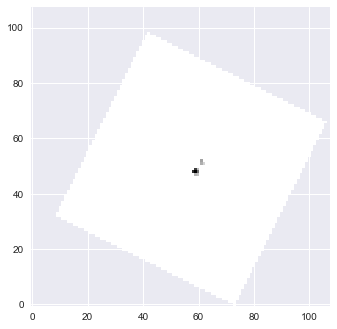

In [34]:
plt.imshow(mflib[ic+8,jc-5,0])

In [37]:
outkey = fits.HDUList(fits.PrimaryHDU(mask.astype(np.float)))
outkey.writeto(par.exportDir+'/mask.fits',clobber=True)


## Save some memory space by calculating the matched filter only where it matters

In [52]:
x = np.arange(mask.shape[1])
y = np.arange(mask.shape[0])
x,y = np.meshgrid(x,y)
xlist= x[mask]
ylist= y[mask]
trim=30
psftrim = psf.data[:,trim:-trim,trim:-trim]
masktrim = mask[trim:-trim,trim:-trim]
mflib2 = np.zeros(list(xlist.shape)+list(psftrim.shape))
mflib2.shape


(440, 19, 48, 48)

In [56]:
ic = mask.shape[0]//2 # i or x axis is horizontal
jc = mask.shape[1]//2 # j or y axis is vertical
for ii in range(len(xlist)):
    i = xlist[ii]
    j = ylist[ii]
    if ii%10==0: print ii
    decentered = Image(data=shiftCube(psftrim,dx=-1*(i-ic),dy=-1*(j-jc)))
    mflib2[ii] = mf(decentered,masktrim,threshold)
outkey = fits.HDUList(fits.PrimaryHDU(mflib2))
outkey.writeto(par.exportDir+'/mflib2.fits.gz',clobber=True)
    

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430


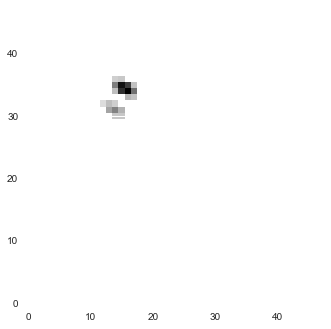

In [63]:
plt.imshow(mflib2[400,0])

In [67]:
outkey = fits.HDUList(fits.PrimaryHDU(xlist.astype(np.int)))
outkey.append(fits.PrimaryHDU(ylist.astype(np.int)))
outkey.writeto(par.exportDir+'/mfcoords.fits.gz',clobber=True)


In [4]:
from crispy.tools.postprocessing import construct_mflib,convolved_mf
psf = Image(par.exportDir+"/offaxis_detector_red_optext.fits")
construct_mflib(par,psf,IWA=3,OWA=9,lamc=770.,threshold=0.5)

crispy - INFO - Read data from HDU 1 of ../../../crispy/SimResults/offaxis_detector_red_optext.fits
crispy - INFO - Read inverse variance from HDU 2 of ../../../crispy/SimResults/offaxis_detector_red_optext.fits


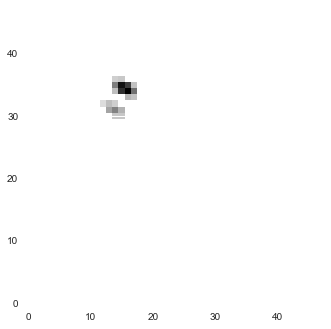

In [5]:
load_mflib = fits.open(par.exportDir+'/mflib.fits.gz')[0].data
plt.imshow(load_mflib[400,0])

In [7]:
from crispy.tools.postprocessing import convolved_mf

# incube = fits.open(par.exportDir+'/average_target_star_detector_red_optext.fits')[1].data
incube = fits.open(par.exportDir+'/test_lstsqdiff.fits')[1].data
convolved = convolved_mf(incube,par.exportDir+'/mflib.fits.gz')
outkey = fits.HDUList(fits.PrimaryHDU(convolved.astype(np.float)))
outkey.writeto(par.exportDir+'/mfcube.fits',clobber=True)
pixstd = [np.nanstd(convolved[i]) for i in range(incube.shape[0])]
print pixstd

[64.455354713045423, 75.475755767119367, 65.188572004891313, 56.121335808348505, 60.059832054065161, 68.629079764543306, 71.255331145110972, 69.309276761441495, 65.104223524485619, 59.904082580834967, 53.725467493148962, 48.763303258414034, 45.483175653996057, 42.770059094868706, 40.226208821409514, 37.548135764936113, 35.913047802042129, 33.413153686736322, 25.096430152400806]


# More recent Matched filter analysis (Comparison with aperture photometry)

In [ ]:
%pylab inline --no-import-all
from crispy.tools.image import Image
test = Image('/Users/mrizzo/IFS/OS5_SIM_2.0_t1000/average/offaxis_star_red_optext.fits')
from crispy.tools.postprocessing import mf
from crispy.tools.imgtools import bowtie
ydim,xdim = test.data[0].shape
lamc=660
IWA=2.5
OWA=9
mask,scratch = bowtie(test.data[0],ydim//2-1,xdim//2,openingAngle=65,
        clocking=-par.philens*180./np.pi,
        IWApix=IWA*lamc/par.lenslet_wav/par.lenslet_sampling,
        OWApix=OWA*lamc/par.lenslet_wav/par.lenslet_sampling,
        export=None,twomasks=False)    

matched_filter = mf(test,mask,0.5)
fig = matched_filter[10,40:60,50:70]
plt.imshow(fig,cmap='viridis')
plt.axis('off')
plt.colorbar()
plt.show()
print np.nansum(fig)
print np.sqrt(np.nansum(fig**2))
print (np.nansum(fig**3)/(np.nansum(fig**2))**2)
print fig[np.nonzero(fig)]

fig = test.data[10,40:60,50:70]
fig/=np.amax(fig)
fig[fig<0.0] = 0.0
plt.imshow(fig,cmap='viridis')
plt.colorbar()
plt.axis('off')
plt.show()

print np.nansum(fig)
print np.sqrt(np.nansum(fig**2))
print (np.nansum(fig**3)/(np.nansum(fig**2))**2)
#print fig[np.nonzero(fig)]


In [ ]:
def mf2(cube,mask,threshold):
    '''
    Matched filter function
    
    Parameters
    ----------
    cube: 3D ndarray
        An IFS cube representing the offaxis PSF, from which to compute the matched filter
    mask: 2D ndarray
        This is typically the coronagraphic mask
    threshold: float
        Fraction of max below which we crop the normalized PSF
    
    Returns
    -------
    matched_filter: 3D ndarray
        Matched filter with the same dimensions as input cube
    
    '''
    matched_filter = np.zeros(cube.data.shape)
    
    for slicenum in range(cube.data.shape[0]):
        cube_norm = cube.data[slicenum]/np.nansum(cube.data[slicenum])
        msk = mask*(cube_norm>np.nanmax(cube_norm)*threshold)
        
        # zero out all pixels outside of the thresholded area
        cube_norm[~msk]=0.0
        
        # normalize
        cube_norm /= np.nansum(cube_norm)
        
        # this is now the final matched filter coefficients
        matched_filter[slicenum,:,:] = cube_norm#/np.nansum(cube_norm**2)
    return matched_filter

matched_filter2 = mf2(test,mask,0.0)
matched_filter3 = mf2(test,mask,0.2)
fig2 = matched_filter2[10,40:60,50:70]
fig3 = matched_filter3[10,40:60,50:70]
plt.imshow(fig,cmap='viridis')
plt.axis('off')
plt.colorbar()
plt.show()
print np.nansum(fig3)
print np.sqrt(np.nansum(fig3**2))
print (np.nansum(fig3**3)/(np.nansum(fig3**2))**2)
print fig3[np.nonzero(fig3)]
print np.sum(fig2[fig2/np.amax(fig2)>0.5])
print fig2[fig2/np.amax(fig2)>0.5]